In [1]:
#concern with the config.ini file


In [2]:
%run "../keras-retinanet/keras_retinanet/bin/train.py" --weights ../keras-retinanet/Models/resnet50_coco_best_v2.1.0.h5 \
--batch-size 2 --steps 75 --epochs 30 \
--snapshot-path ../Data \
--random-transform \
--config test_config.ini \
csv ../Images/Harbor_Seals_Tile/harbor_train_annotations.csv ../Images/Harbor_Seals_Tile/harbor_classes.csv \
--val-annotations ../Images/Harbor_Seals_Tile/harbor_val_annotations.csv

pre parse
post arg
post generator
Creating model, this may take a second...


Using TensorFlow backend.


model summary here
start training
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 3.7010 - regression_loss: 2.6566 - classification_loss: 1.0444  

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:18 Time:  0:00:18
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.0435
mAP: 0.0435

Epoch 00001: saving model to ../Data\resnet50_csv_01.h5
75/75 [==============================] - 6320s 84s/step - loss: 3.7010 - regression_loss: 2.6566 - classification_loss: 1.0444
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 2.9610 - regression_loss: 2.3058 - classification_loss: 0.6552 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:18 Time:  0:00:18
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.1890
mAP: 0.1890

Epoch 00002: saving model to ../Data\resnet50_csv_02.h5
75/75 [==============================] - 1553s 21s/step - loss: 2.9610 - regression_loss: 2.3058 - classification_loss: 0.6552
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 2.5541 - regression_loss: 2.0965 - classification_loss: 0.4575 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:28 Time:  0:00:28
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.2667
mAP: 0.2667

Epoch 00003: saving model to ../Data\resnet50_csv_03.h5
75/75 [==============================] - 1328s 18s/step - loss: 2.5541 - regression_loss: 2.0965 - classification_loss: 0.4575
Epoch 4/30
75/75 [==============================] - ETA: 0s - loss: 2.4797 - regression_loss: 2.0321 - classification_loss: 0.4476 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:35 Time:  0:00:35
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.3231
mAP: 0.3231

Epoch 00004: saving model to ../Data\resnet50_csv_04.h5
75/75 [==============================] - 1732s 23s/step - loss: 2.4797 - regression_loss: 2.0321 - classification_loss: 0.4476
Epoch 5/30
75/75 [==============================] - ETA: 0s - loss: 2.3263 - regression_loss: 1.9204 - classification_loss: 0.4059 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:25 Time:  0:00:25
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.3780
mAP: 0.3780

Epoch 00005: saving model to ../Data\resnet50_csv_05.h5
75/75 [==============================] - 1148s 15s/step - loss: 2.3263 - regression_loss: 1.9204 - classification_loss: 0.4059
Epoch 6/30
75/75 [==============================] - ETA: 0s - loss: 2.2787 - regression_loss: 1.8984 - classification_loss: 0.3803 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:16 Time:  0:00:16
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.3975
mAP: 0.3975

Epoch 00006: saving model to ../Data\resnet50_csv_06.h5
75/75 [==============================] - 2920s 39s/step - loss: 2.2787 - regression_loss: 1.8984 - classification_loss: 0.3803
Epoch 7/30
75/75 [==============================] - ETA: 0s - loss: 2.2014 - regression_loss: 1.8378 - classification_loss: 0.3636 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:22 Time:  0:00:22
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.4038
mAP: 0.4038

Epoch 00007: saving model to ../Data\resnet50_csv_07.h5
75/75 [==============================] - 945s 13s/step - loss: 2.2014 - regression_loss: 1.8378 - classification_loss: 0.3636
Epoch 8/30
75/75 [==============================] - ETA: 0s - loss: 2.1825 - regression_loss: 1.8196 - classification_loss: 0.3628 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:17 Time:  0:00:17
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.4055
mAP: 0.4055

Epoch 00008: saving model to ../Data\resnet50_csv_08.h5
75/75 [==============================] - 2593s 35s/step - loss: 2.1825 - regression_loss: 1.8196 - classification_loss: 0.3628
Epoch 9/30
75/75 [==============================] - ETA: 0s - loss: 2.1305 - regression_loss: 1.7895 - classification_loss: 0.3410 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:19 Time:  0:00:19
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.3792
mAP: 0.3792

Epoch 00009: saving model to ../Data\resnet50_csv_09.h5
75/75 [==============================] - 2049s 27s/step - loss: 2.1305 - regression_loss: 1.7895 - classification_loss: 0.3410
Epoch 10/30
75/75 [==============================] - ETA: 0s - loss: 2.1161 - regression_loss: 1.7801 - classification_loss: 0.3360 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:37 Time:  0:00:37
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.3878
mAP: 0.3878

Epoch 00010: saving model to ../Data\resnet50_csv_10.h5
75/75 [==============================] - 1555s 21s/step - loss: 2.1161 - regression_loss: 1.7801 - classification_loss: 0.3360
Epoch 11/30
75/75 [==============================] - ETA: 0s - loss: 2.0934 - regression_loss: 1.7600 - classification_loss: 0.3333 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:37 Time:  0:00:37
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.4126
mAP: 0.4126

Epoch 00011: saving model to ../Data\resnet50_csv_11.h5
75/75 [==============================] - 1775s 24s/step - loss: 2.0934 - regression_loss: 1.7600 - classification_loss: 0.3333
Epoch 12/30
75/75 [==============================] - ETA: 0s - loss: 2.0290 - regression_loss: 1.7163 - classification_loss: 0.3127 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:44 Time:  0:00:44
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.4416
mAP: 0.4416

Epoch 00012: saving model to ../Data\resnet50_csv_12.h5
75/75 [==============================] - 1725s 23s/step - loss: 2.0290 - regression_loss: 1.7163 - classification_loss: 0.3127
Epoch 13/30
75/75 [==============================] - ETA: 0s - loss: 2.0601 - regression_loss: 1.7336 - classification_loss: 0.3265 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:38 Time:  0:00:38
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.4419
mAP: 0.4419

Epoch 00013: saving model to ../Data\resnet50_csv_13.h5
75/75 [==============================] - 1765s 24s/step - loss: 2.0601 - regression_loss: 1.7336 - classification_loss: 0.3265
Epoch 14/30
75/75 [==============================] - ETA: 0s - loss: 2.0405 - regression_loss: 1.7260 - classification_loss: 0.3145 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:32 Time:  0:00:32
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.4326
mAP: 0.4326

Epoch 00014: saving model to ../Data\resnet50_csv_14.h5

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
75/75 [==============================] - 3028s 40s/step - loss: 2.0405 - regression_loss: 1.7260 - classification_loss: 0.3145
Epoch 15/30
75/75 [==============================] - ETA: 0s - loss: 1.9857 - regression_loss: 1.6788 - classification_loss: 0.3070 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:39 Time:  0:00:39
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.4400
mAP: 0.4400

Epoch 00015: saving model to ../Data\resnet50_csv_15.h5
75/75 [==============================] - 1731s 23s/step - loss: 1.9857 - regression_loss: 1.6788 - classification_loss: 0.3070
Epoch 16/30
75/75 [==============================] - ETA: 0s - loss: 2.0118 - regression_loss: 1.7008 - classification_loss: 0.3110 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:20 Time:  0:00:20
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.4275
mAP: 0.4275

Epoch 00016: saving model to ../Data\resnet50_csv_16.h5
75/75 [==============================] - 4398s 59s/step - loss: 2.0118 - regression_loss: 1.7008 - classification_loss: 0.3110
Epoch 17/30
75/75 [==============================] - ETA: 0s - loss: 1.9487 - regression_loss: 1.6550 - classification_loss: 0.2936 

Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:28 Time:  0:00:28
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.4435
mAP: 0.4435

Epoch 00017: saving model to ../Data\resnet50_csv_17.h5
75/75 [==============================] - 1547s 21s/step - loss: 1.9487 - regression_loss: 1.6550 - classification_loss: 0.2936


In [3]:
'''

! "../keras-retinanet/keras_retinanet/bin/train.py" \
--imagenet-weights \
--epoch 3 \
--batch-size 1 \
--steps 1 \
--snapshot-path ../Data 
--tensorboard-dir <log directory for Tensorboard output> \
pascal <path to dataset directory>
'''

'\n\n! "../keras-retinanet/keras_retinanet/bin/train.py" --imagenet-weights --epoch 3 --batch-size 1 --steps 1 --snapshot-path ../Data \n--tensorboard-dir <log directory for Tensorboard output> pascal <path to dataset directory>\n'

In [10]:
#first arg is the model to convert, second is the path to save the model to
%run "../keras-retinanet/keras_retinanet/bin/convert_model.py" --config test_config.ini ../Data/resnet50_csv_17.h5 ../Data/final_model_harbor_seal.h5

In [16]:
#evaluate the model on the test set
#first arg is test annotations, second is classes, third is (converted) model
#classes must be in same dir as the tiled images
%run "../keras-retinanet/keras_retinanet/bin/evaluate.py" csv ../Images/Harbor_Seals_Tile/harbor_test_annotations.csv ../Images/Harbor_Seals_Tile/harbor_classes.csv ../Data/final_model_harbor_seal.h5

Loading model, this may take a second...


Running network: 100% (13 of 13) |#######| Elapsed Time: 0:00:39 Time:  0:00:39
Parsing annotations: 100% (13 of 13) |###| Elapsed Time: 0:00:00 Time:  0:00:00


131 instances of class seal with average precision: 0.6020
Inference time for 13 images: 2.9267
mAP using the weighted average of precisions among classes: 0.6020
mAP: 0.6020


In [17]:
#evaluate the model on the val set
%run "../keras-retinanet/keras_retinanet/bin/evaluate.py" csv ../Images/Harbor_Seals_Tile/harbor_val_annotations.csv ../Images/Harbor_Seals_Tile/harbor_classes.csv ../Data/final_model_harbor_seal.h5

Loading model, this may take a second...


Running network: 100% (12 of 12) |#######| Elapsed Time: 0:00:36 Time:  0:00:36
Parsing annotations: 100% (12 of 12) |###| Elapsed Time: 0:00:00 Time:  0:00:00


97 instances of class seal with average precision: 0.4435
Inference time for 12 images: 2.9777
mAP using the weighted average of precisions among classes: 0.4435
mAP: 0.4435


In [18]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

import keras

from keras_retinanet.models import retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color


import matplotlib.pyplot as plt
import cv2
import sys
import os
import numpy as np
import time
import json
from random import shuffle

import tensorflow as tf

def get_session():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(get_session())

In [19]:
sys.path.insert(0, '../keras-retinanet/keras_retinanet')
from utils.gpu import setup_gpu

# use this to change which GPU to use
gpu = '1'

# set the modified tf session as backend in keras
setup_gpu(gpu)

#tf.config.threading.set_inter_op_parallelism_threads(20) 

RuntimeError: Inter op parallelism cannot be modified after initialization.

In [20]:
model_path = '../Data/final_model_harbor_seal.h5'

#print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')

print(model.summary())

labels_to_names = {0: 'seal'}

Model: "retinanet-bbox"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, None, None, 6 0           bn_conv1[0][0]                   
_____________________________________________________________________________________

padding5a_branch2b (ZeroPadding (None, None, None, 5 0           res5a_branch2a_relu[0][0]        
__________________________________________________________________________________________________
res5a_branch2b (Conv2D)         (None, None, None, 5 2359296     padding5a_branch2b[0][0]         
__________________________________________________________________________________________________
bn5a_branch2b (BatchNormalizati (None, None, None, 5 2048        res5a_branch2b[0][0]             
__________________________________________________________________________________________________
res5a_branch2b_relu (Activation (None, None, None, 5 0           bn5a_branch2b[0][0]              
__________________________________________________________________________________________________
res5a_branch2c (Conv2D)         (None, None, None, 2 1048576     res5a_branch2b_relu[0][0]        
__________________________________________________________________________________________________
res5a_bran

In [22]:
import os
image_dir = "../Images/Harbor_Seals_Tile/"

image_list = []
for root, dirs, files in os.walk(image_dir):
    for filename in files:
        if filename.lower().endswith(('.png')):
            image_list.append(image_dir + filename)
print(len(image_list))

3080


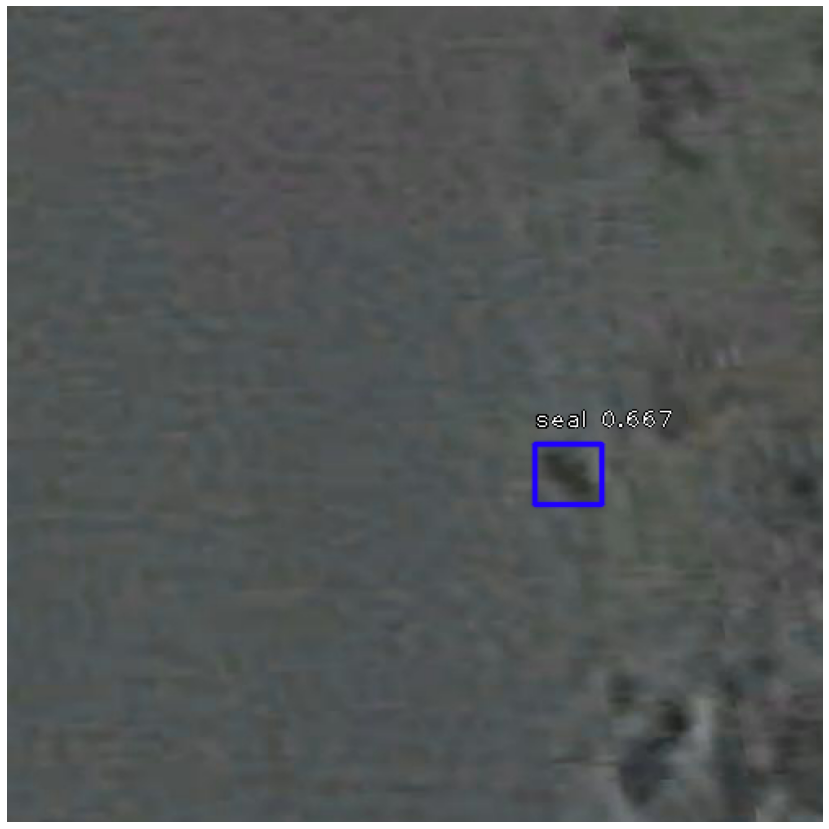

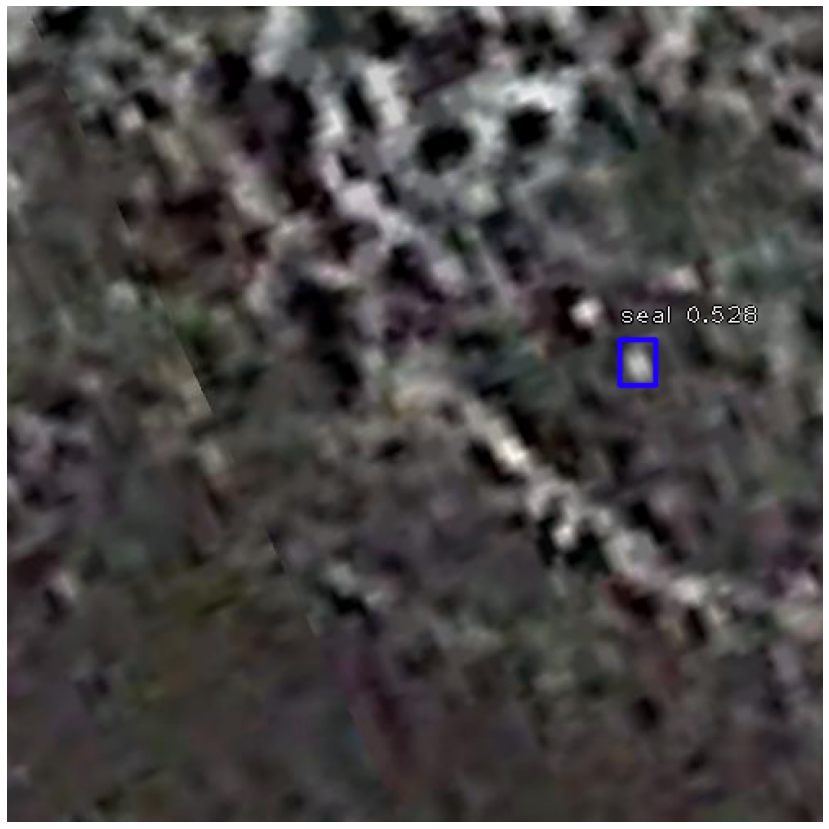

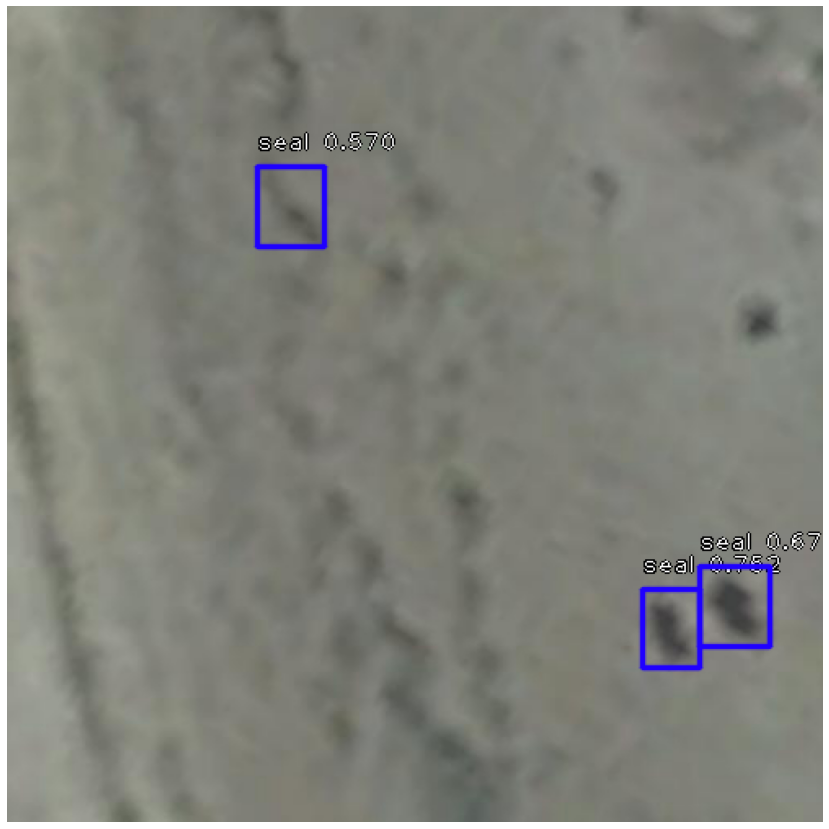

Finished, time per image: 0.010750396143306385


In [23]:
visualize = True
min_score = 0.5

detections = {}

total_time = 0

count = 0
detection_iterations = 10
shuffle(image_list)

for image_path in image_list: 
    if count > detection_iterations:
        break
    else: 
        count +=1
    
    image = read_image_bgr(image_path)
    
    if visualize:
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    total_time += time.time() - start 
    
    boxes /= scale
    if any(score >= min_score for score in scores [0]):
        detections[image_path] = []
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < min_score:
            break
        
        b = box.astype(int)
        detections[image_path].append({"box" : b, "label" : label, "score" : score})
        
        if visualize: 
            color = label_color(label)
            
            draw_box(draw, b, color=color)
            
            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)
            
    if any(score >= min_score for score in scores[0]):
        if visualize:
            plt.figure(figsize=(15, 15))
            plt.axis('off')
            plt.imshow(draw)
            plt.show()
            
print("Finished, time per image:", total_time/len(image_list))

In [24]:
min_score = 0.5

detections = {}

total_time = 0

for image_path in image_list:
    
    image = read_image_bgr(image_path)
          
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    total_time += time.time() - start
    
    boxes /= scale  
        
    if any(score >= min_score for score in scores[0]):
        detections[image_path] = []
        
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < min_score:
            break
        
        b = box.astype(int)    
        detections[image_path].append({"box" : b, "label" : label, "score" : score})
        
            
print("Finished, time per image:", total_time/len(image_list))

Finished, time per image: 4.787084420547857


In [25]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [26]:
with open('../Test_Output/detections.json', 'w') as fp:
    json.dump(detections, fp, cls=MyEncoder)

In [28]:
print(len(detections))

648
